# Counting objects workflow

---
*Introduction to Image Analysis Workshop*

*Stefania Marcotti (stefania.marcotti@kcl.ac.uk)*

*Intro to building image analysis pipelines with Python*

*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

In this notebook we will illustrate a simple workflow, consisting of a number of simple steps, designed to accomplish the goal of **counting objects in a microscopy image**. 

You will learn how to:

* Open images
* Use filters to suppress noise
* Segment images using grey level thresholding
* Count objects
* Perform basic morphological quantification

### Import libraries
Python is organised in modules and packages. To make them available in our current notebook, we use the keywork `import`. We can also import specific functions by using the syntax [`from` module `import` function]. Additionally, we can define aliases for modules' names with the keyword `as`

You can check the documentation for the various modules if you want to know more!

* [`numpy`](https://numpy.org/) - scientific computing
* [`scikit_image`](https://scikit-image.org/docs/stable/api/skimage.html) (a.k.a. [`skimage`](https://scikit-image.org/docs/stable/api/skimage.html)) - image processing and computer vision
* [`matplotlib`](https://matplotlib.org/) - visualisations
* [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) - data managing

In [1]:
import numpy as np

from skimage import io
from skimage import filters
from skimage import measure

import matplotlib.pyplot as plt

import pandas as pd

### Open images

To get started with our "counting objects" task, the first thing we need to do is to open an image. We will use as example image [`003003-10.tif`](https://github.com/RMS-DAIM/introduction-to-image-analysis/blob/main/Data/idr0028/003003-10.tif), where some cells have been stained for *nuclei (Hoescht, ch0)*, *tubulin (AlexaFluor568, ch1)*, *actin (AlexaFluor488, ch2)*, and *YAP/TAZ (AlexaFluor647, ch3)* and imaged with fluorescent microscopy. You can find more information about this [public image dataset](https://idr.openmicroscopy.org/webclient/?show=plate-5679) in [the associated publication](https://www.nature.com/articles/sdata201718).

Next, we will display our example image to screen - it's always good practice to get an idea about the kind of data we're working with! We will be working only with the nuclei (ch0), so we will need to make sure to select the correct channel.

In [3]:
# read .tif file
im_read = io.imread('../data/003003-10.tif')

In [4]:
# print image type
print('Image type:', type(im_read))

Image type: <class 'numpy.ndarray'>


In [4]:
# print image dimensions
print('Image dimensions:', im_read.shape)

Image dimensions: (501, 667, 4)


The image dimensions are currently in the (y, x, c) format. Ideally, by convention, we would want the dimensions of the image to be (c, x, y). We can rearrange the dimensions by using the numpy function `transpose`.

In [5]:
# rearrange channels
im_all = np.transpose(im_read, (2, 0, 1))
print('New image dimensions:', im_all.shape)

New image dimensions: (4, 501, 667)


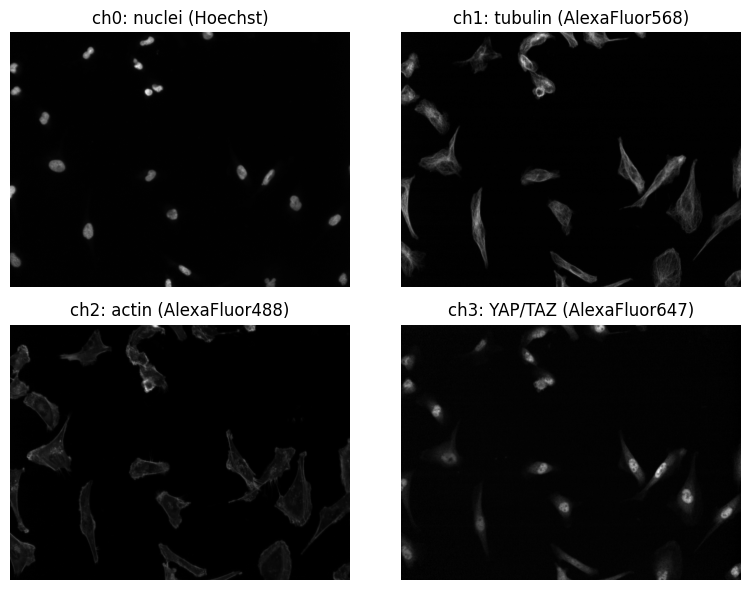

In [6]:
# display all channels 
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0, 0].imshow(im_all[0,], cmap='gray')
axs[0, 0].set_title('ch0: nuclei (Hoechst)')
axs[0, 0].axis('off')

axs[0, 1].imshow(im_all[1,], cmap='gray')
axs[0, 1].set_title('ch1: tubulin (AlexaFluor568)')
axs[0, 1].axis('off')

axs[1, 0].imshow(im_all[2,], cmap='gray')
axs[1, 0].set_title('ch2: actin (AlexaFluor488)')
axs[1, 0].axis('off')

axs[1, 1].imshow(im_all[3,], cmap='gray')
axs[1, 1].set_title('ch3: YAP/TAZ (AlexaFluor647)')
axs[1, 1].axis('off')

plt.tight_layout()

In [6]:
# select the channel containing the nuclei
im = im_all[0,]

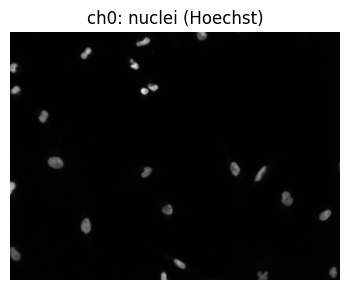

In [8]:
# display image
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im, cmap='gray')
ax.set_title('ch0: nuclei (Hoechst)')
ax.axis('off')
plt.tight_layout()

### Use filters to suppress noise

Many image processing tasks include filtering to suppress noise, improve signal-to-noise ratio, or bring out the features of the image we are interested in.

Please keep in mind that often by applying filters we change the histogram of the image, and, therefore, we won't be able to perform some quantifications related to signal intensity **after** filtering.

In this example, we are not interested in quantifying signal intensities (i.e., how bright the nuclei are), so we're good to proceed!

[`skimage`](https://scikit-image.org/docs/stable/api/skimage.html) has many filters already built in! You can find them in the submodule [`skimage.filters`](https://scikit-image.org/docs/stable/api/skimage.filters.html).

Here we'll test a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur), which is a standard method to reduce image noise by blurring details. One important parameter is `sigma`, which is the standard deviation of the Gaussian kernel. You can think of it as the "size of the brush" you'll use to smooth the image features.

In [7]:
# Gaussian blur (sigma=5)
im_gauss = filters.gaussian(im, sigma=5)

In [8]:
im_gauss

array([[0.00019141, 0.00019584, 0.0002003 , ..., 0.00036153, 0.00036669,
        0.00037169],
       [0.00018934, 0.0001935 , 0.00019766, ..., 0.00035935, 0.00036411,
        0.00036863],
       [0.00018861, 0.00019234, 0.00019605, ..., 0.00035741, 0.0003618 ,
        0.0003659 ],
       ...,
       [0.00020558, 0.00020873, 0.00021202, ..., 0.00109979, 0.00097283,
        0.00086909],
       [0.00019834, 0.00020233, 0.00020654, ..., 0.00100057, 0.00089988,
        0.00081746],
       [0.00019009, 0.00019505, 0.00020031, ..., 0.00091906, 0.00084077,
        0.00077642]])

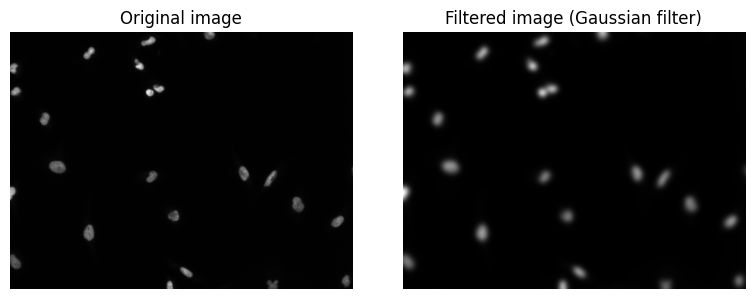

In [10]:
# display original image next to filtered one
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(im_gauss, cmap='gray')
axs[1].set_title('Filtered image (Gaussian filter)')
axs[1].axis('off')

plt.tight_layout()

<div style="background-color:#abd9e9; border-radius: 5px; padding: 10pt"><strong>Task</strong> Using the templates below, create a new image called <code>im_gauss_test</code> with a different value for sigma and display it next to the original image - what do you notice? </div>

In [ ]:
# Gaussian blur (sigma=? YOU DECIDE!)
im_gauss_test = ...

In [ ]:
# display original image next to filtered one (im_gauss_test)
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

# add your code to visualise the new image here

plt.tight_layout()

### Segment images using grey level thresholding

The next step in our pipeline is segmentation. This is the process by which we separate the foreground (`True`) from the background (`False`) so that the subsequent analyses are performed only on the regions of interest.

One simple way to segment images is by gray level thresholding: we "keep" all the pixels with values above a threshold (foreground) and we "discard" the rest (background).

There are different ways to set this threshold by exploiting different algorigthms. With the function [`skimage.filters.try_all_threshold`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold), we can visualise a few options and decide which one performs best for our data! [Otsu's thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method) is a common choice for this type of images, so after checking its performance on the example image, we'll apply it.

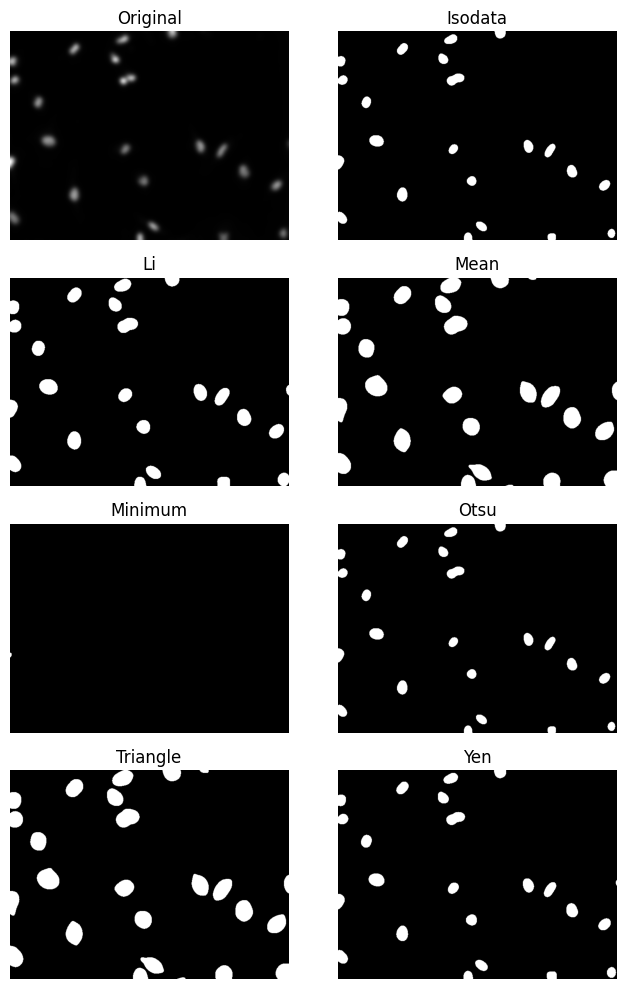

In [11]:
# display various options for gray level thresholding
fig, ax = filters.try_all_threshold(im_gauss, figsize=(8,10), verbose=False)
plt.tight_layout()

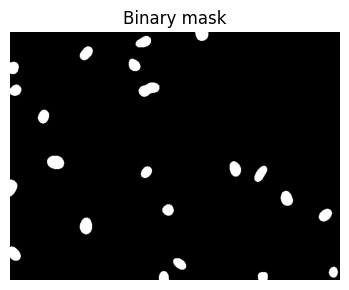

In [12]:
# Otsu thresholding performs quite well in this example, so we'll proceed by applying it to our image and display 
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss >= thresh

# display the binary mask
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im_thresh, cmap='gray')
ax.set_title('Binary mask')
ax.axis('off')
plt.tight_layout()

<div style="background-color:#abd9e9; border-radius: 5px; padding: 10pt"><strong>Task</strong> Can you spot another thresholding method that works well on this image? Test it below! </div>

In [ ]:
# Choose a different thresholding method among the ones displayed above!
thresh_other = ...
im_thresh_other = im_gauss >= thresh_other

# display the binary mask
fig, ax = plt.subplots(figsize=(4,3))
# add your code to visualise your image here
ax.axis('off')
plt.tight_layout()

### Count objects

One way to count the objects in our thresholded image is to exploit the function [`skimage.measure.label`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label). This function labels connected regions in the image with an integer, ultimately assigning a label to each object.

After labelling, counting the objects is equivalent to counting the number of labels available in the image!

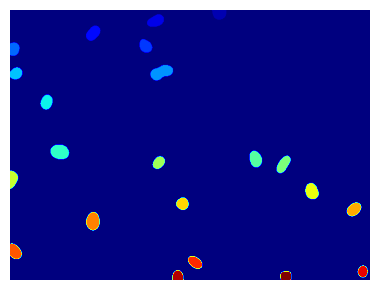

In [13]:
# label objects and visualise the result
labels = measure.label(im_thresh)

fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(labels, cmap='jet')
ax.axis('off')
plt.tight_layout()


In [14]:
# count the objects - find the maximum integer assigned to a label!
print('There are', labels.max(), 'objects in the image')

There are 22 objects in the image


### Perform basic morphological quantification
We can perform some basic morphological quantification by using the function [`skimage.measure.regionprops_table`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table). Check the documentation to see all the different output we can obtain!

In this example, we are going to show the area, centroid (y and x coordinates), and eccentricity for each blob. We are going to save the data in a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which is a data structure containing labelled axes (one row for each object, one column for each feature).

In [15]:
# measure properties
props = measure.regionprops_table(labels, im, properties=['area', 'centroid', 'eccentricity'])
props_df = pd.DataFrame(props)

props_df.head(5)

,area,centroid-0,centroid-1,eccentricity
0,395.0,7.346835,387.491139,0.712265
1,534.0,19.773408,269.709738,0.784994
2,519.0,42.551060,153.734104,0.754241
3,458.0,66.425764,250.781659,0.618282
4,381.0,71.950131,7.585302,0.702387


In [16]:
# add image and object ID to dataframe
props_df['image_ID'] = '003003-10.tif'
props_df['object_ID'] = props_df.index+1

props_df.head()

,area,centroid-0,centroid-1,eccentricity,image_ID,object_ID
0,395.0,7.346835,387.491139,0.712265,003003-10.tif,1
1,534.0,19.773408,269.709738,0.784994,003003-10.tif,2
2,519.0,42.551060,153.734104,0.754241,003003-10.tif,3
3,458.0,66.425764,250.781659,0.618282,003003-10.tif,4
4,381.0,71.950131,7.585302,0.702387,003003-10.tif,5


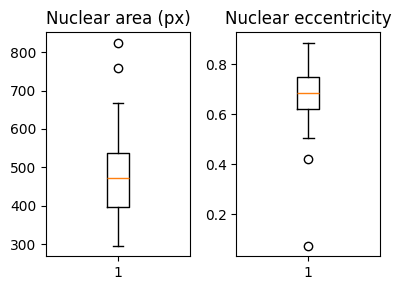

In [17]:
# display some results
fig, axs = plt.subplots(1, 2, figsize=(4,3))

axs[0].boxplot(props_df['area'])
axs[0].set_title('Nuclear area (px)')

axs[1].boxplot(props_df['eccentricity'])
axs[1].set_title('Nuclear eccentricity')

plt.tight_layout()

### Bonus track
It is always good practice to visualise our results! So we can now display on the segmented image some of the basic morphological parameters we obtained. As an example, we show the centroids of each blob as a magenta dot. Can you spot where things have not gone exactly as expected?

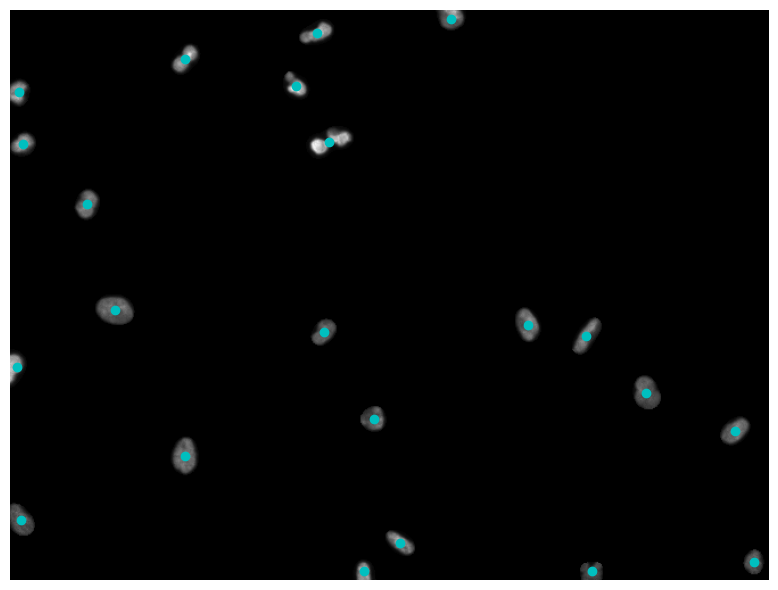

In [18]:
# display segmented image
im_segm = im * im_thresh

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im_segm, cmap='gray')
ax.axis('off')
plt.tight_layout()

# plot centroids
plt.plot(props_df['centroid-1'], props_df['centroid-0'], 'co')
plt.show()

<div style="background-color:#abd9e9; border-radius: 5px; padding: 10pt"><strong>Task</strong> How would we go about running the same pipeline for a different image? </div>

### Further reading
If you're interested in knowing more about image analysis in Python, there are a lot of free resources out there! One good starting point is the [IAFIG-RMS Python for Bioimage Analysis Course](https://github.com/RMS-DAIM/Python-for-Bioimage-Analysis). Good luck with your image analysis adventures!